# Medical Insurance Cost Prediction

## 1. Problem
The cost of medical insurance for each individual depends on many factors such as age, BMI, gender, number of children, geographic region, and smoking habits. So the question is: How to predict an individual's health insurance costs based on demographic and health characteristics?

## 2. Questions We Want to Answer
- Which factors affect insurance costs the most?
- Is the relationship between variables (`age`, `BMI`, `smoker`,…) and `charges` linear?- How accurate can our predictions be?
- Which model works best?

## 3. The plan

### Data & Tools
- **Dataset**: Medical Cost Personal Datasets from Kaggle
- **Libraries**: pandas, matplotlib,seaborn, scikit-learn

### Steps
This notebook includes:
- Data acquisition, inspection, and cleaning
- Exploratory data analysis using statistical summaries and visualizations
- Outlier detection and noise‑handling to improve robustness
- Feature engineering (categorical encoding, scaling, interaction terms)
- Model building with cross‑validation
- Regularization comparison (Lasso vs. Ridge)
- Evaluation using RMSE and R²
- Robustness checks with noise injection

---

SyntaxError: invalid syntax (1310192510.py, line 2)

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import RobustScaler
from sklearn.base import clone



 ## 1. EDA

In [80]:
df = pd.read_csv(r"E:\Project\medical_cost_prediction\insurance.csv")
df.head()   
df.info()
df.describe(include='all')
df.isnull().sum()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

So there are no missing value and the dataset is quite clean,in addition, there a 6 differents features with 3 numerics. We continue by check the distribution of the feature and the correlation between features and charges.

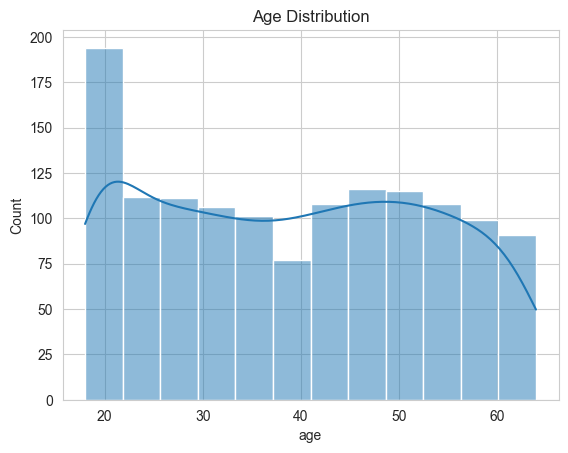

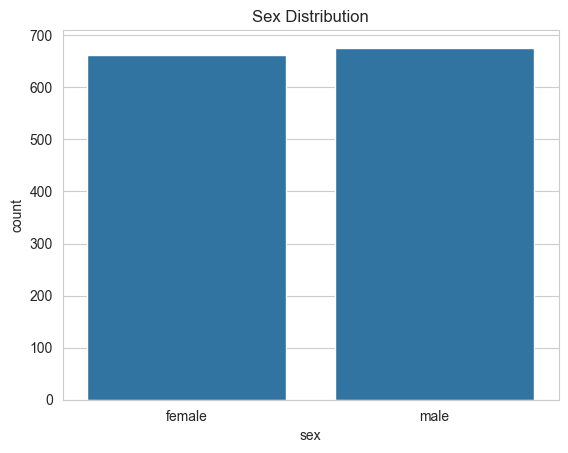

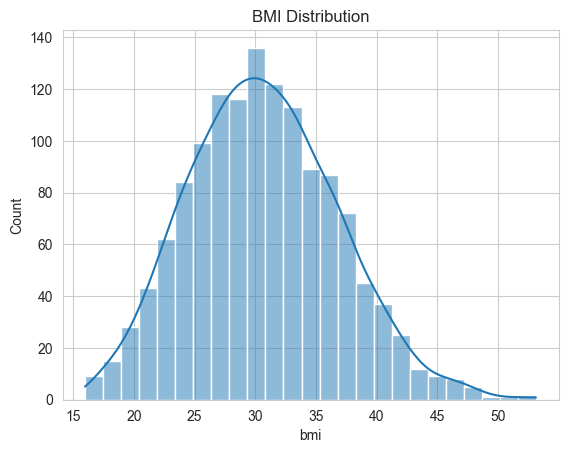

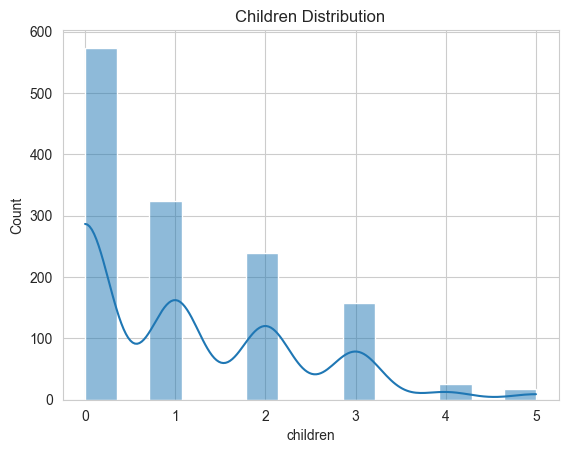

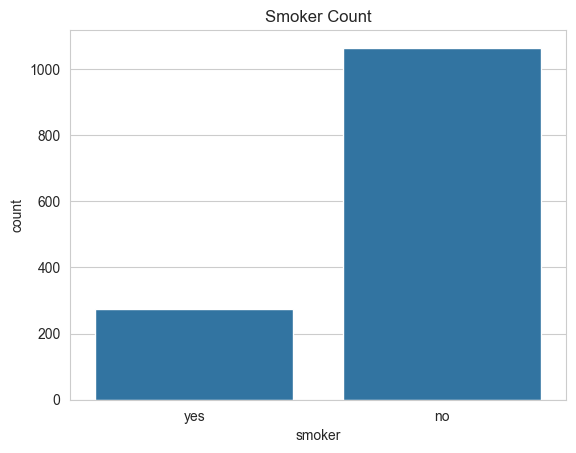

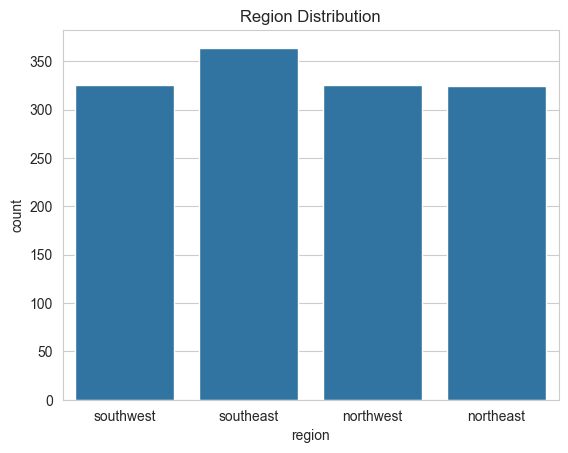

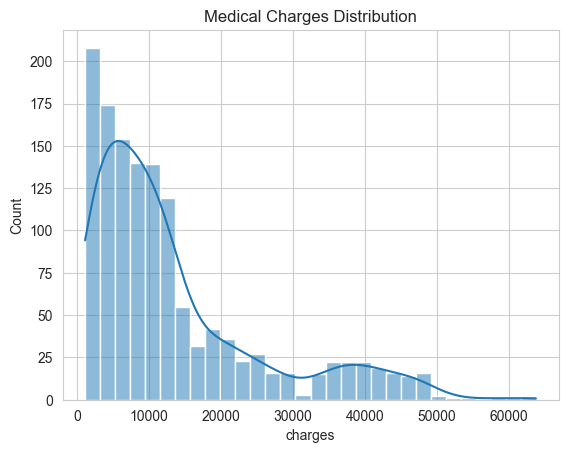

In [81]:
sns.histplot(df['age'], kde=True)
plt.title("Age Distribution")
plt.show()

sns.countplot(x='sex', data=df)
plt.title("Sex Distribution")
plt.show()

sns.histplot(df['bmi'], kde=True)
plt.title("BMI Distribution")
plt.show()

sns.histplot(df['children'], kde=True)
plt.title("Children Distribution")
plt.show()

sns.countplot(x='smoker', data=df)
plt.title("Smoker Count")
plt.show()

sns.countplot(x='region', data=df)
plt.title("Region Distribution")
plt.show()

sns.histplot(df['charges'], kde=True)
plt.title("Medical Charges Distribution")
plt.show()

In [82]:
# Check for outlier (BMI < 10 or >70)
print((df['bmi'] < 10).sum())
print((df['bmi'] > 70).sum())


0
0


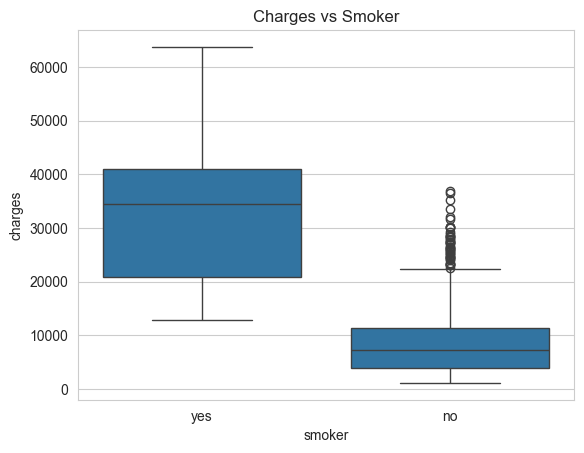

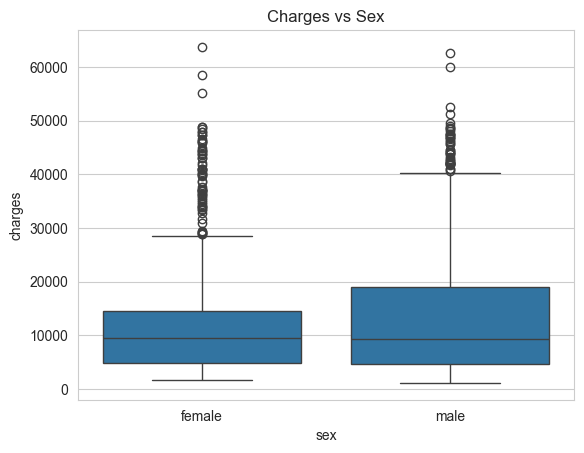

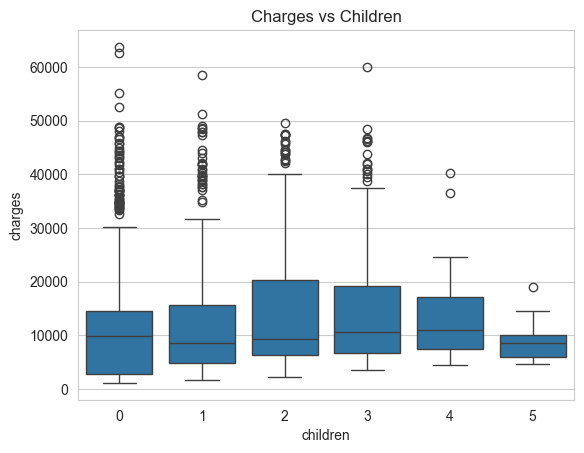

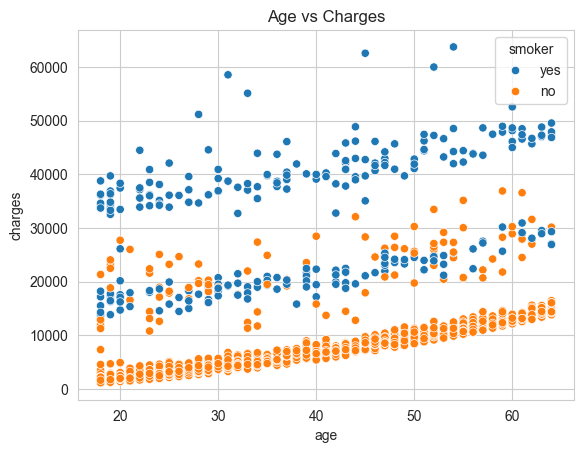

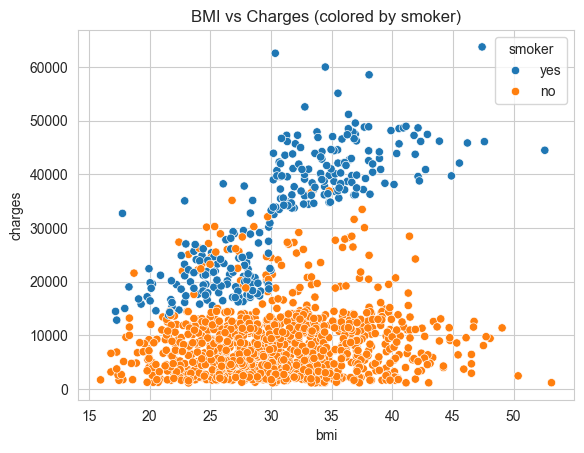

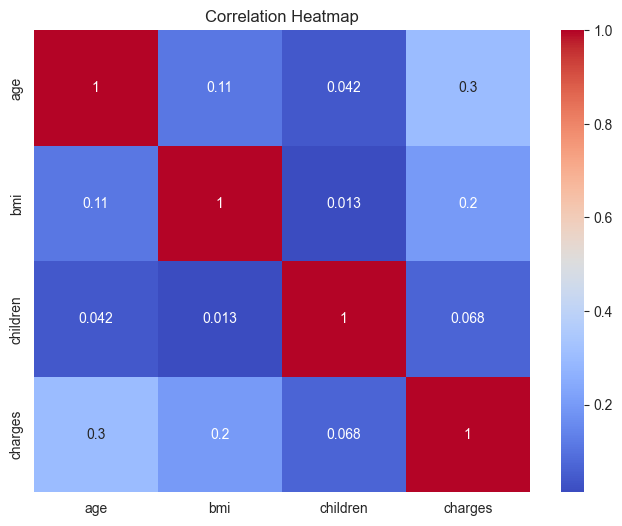

In [83]:
sns.boxplot(x='smoker', y='charges', data=df)
plt.title("Charges vs Smoker")
plt.show()

sns.boxplot(x='sex', y='charges', data=df)
plt.title("Charges vs Sex")
plt.show()

sns.boxplot(x='children', y='charges', data=df)
plt.title("Charges vs Children")
plt.show()

sns.scatterplot(x='age', y='charges', data=df, hue='smoker')
plt.title("Age vs Charges")
plt.show()

sns.scatterplot(x='bmi', y='charges', data=df, hue='smoker')
plt.title("BMI vs Charges (colored by smoker)")
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


### Conclusion
The dataset have a bit bias in young people so there is a notable spike at `age` = 18-20 and `children` = 0 but `children` do not have strong correlation with `charge` so we can skip it. The most correlation feature is `smoke` which increase dramatically the medical charges. Age and BMI features had a linear relationship with charges, especially when grouped into smokers and non-smokers.  
Although the charges data is right skewed but I will let it unchanged to verify the effect of regularization on model robustness

## 2. Preprocessing and Features engineering

In [95]:
df_processed = df.copy()
df_processed['charges'] = winsorize(df['charges'], limits=[0.01, 0.01])

Outliers in medical costs often reflect clinically significant medical cases, so I do not eliminate them completely but choose the Winsorization method to stabilizes linear models.

Winsorization is a technique for treating outliers by limiting extreme values in a dataset rather than removing them. This method replaces values below a lower percentile $p_l$ with the value at $p_l$, and values above an upper percentile $p_u$ with the value at $p_u$.

$$
x_i^{\text{winsorized}} =
\begin{cases}
Q_{p_l}, & \text{if } x_i < Q_{p_l} \\
x_i, & \text{if } Q_{p_l} \le x_i \le Q_{p_u} \\
Q_{p_u}, & \text{if } x_i > Q_{p_u}
\end{cases}
$$

Where:
- $Q_{p_l}$ and $Q_{p_u}$ are the lower and upper quantiles (e.g., 1% and 99%)
- $x_i$ is the original value of the i-th data point
- $x_i^{\text{winsorized}}$ is the value after winsorization  

It means that outliers are replace by a fixed number to stabilize the model.

In [98]:
df_processed['age_bmi'] = df_processed['age'] * df_processed['bmi']
df_processed['smoke_bmi'] = df_processed['bmi'] * (df_processed['smoker'] == 'yes').astype(int)
df_processed['smoke_age'] = df_processed['age'] * (df_processed['smoker'] == 'yes').astype(int)
categorical_cols = ['sex', 'smoker', 'region']  
df_encoded = pd.get_dummies(df_processed, 
                            columns=categorical_cols, 
                            drop_first=True,
                            dtype=int)

I create new interaction features because EDA show that smoke effects strongly in medical cost of differents age and bmi.  
Then categorical features are encoded so that linear model can process it.  

In [99]:
X = df_encoded.drop('charges', axis=1)
y = df_encoded['charges']

numerical_features = ['age', 'bmi', 'children', 'age_bmi', 'smoke_bmi', 'smoke_age']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=19
)



## 3. Training model

In [87]:
preprocess = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_features)
    ],
    remainder='passthrough'
)

This data contains natural outliers and skewed distributions that represent real clinical scenarios. Traditional scaling methods like StandardScaler can be unduly influenced by these extreme values, leading to biased transformations so I chosed RobustScaler.  
RobustScaler is a scaling technique that uses robust statistics to scale features, making it resistant to outliers. Unlike StandardScaler which uses mean and standard deviation, RobustScaler uses median and interquartile range (IQR). Its formula :  

For each feature $x$:

$$
x_i^{\text{scaled}} = \frac{x_i - \text{median}(x)}{\text{IQR}(x)}
$$

Where:
- $\text{median}(x)$ is the median of feature $x$
- $\text{IQR}(x) = Q_3(x) - Q_1(x)$ is the interquartile range
- $Q_1(x)$ is the 25th percentile (first quartile)
- $Q_3(x)$ is the 75th percentile (third quartile)  

This method provides stable scaling despite data anomalies, helps the model unaffected by extreme values in data tails and it bases on robust statistic. 



In [88]:

ridge_pipeline = Pipeline([
    ('pre', preprocess),
    ('model', Ridge())
])

alphas = np.logspace(-3, 3, 50)
grid_ridge = GridSearchCV(
    estimator=ridge_pipeline,
    param_grid={'model__alpha': alphas},  
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    return_train_score=True
)

grid_ridge.fit(X_train, y_train)

best_ridge_alpha = grid_ridge.best_params_['model__alpha']
best_ridge_model = grid_ridge.best_estimator_

ridge_cv_mse = -grid_ridge.cv_results_['mean_test_score']

print("Best Ridge alpha:", best_ridge_alpha)



Best Ridge alpha: 0.1206792640639329


In [89]:
lasso_pipeline = Pipeline([
    ('pre', preprocess),
    ('model', Lasso(max_iter=5000))
])

alphas = np.logspace(-3, 3, 50)
grid_lasso = GridSearchCV(
    estimator=lasso_pipeline,
    param_grid={'model__alpha': alphas},  # alpha thuộc step 'model'
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    return_train_score=True
)

grid_lasso.fit(X_train, y_train)

best_lasso_alpha = grid_lasso.best_params_['model__alpha']
best_lasso_model = grid_lasso.best_estimator_

lasso_cv_mse = -grid_lasso.cv_results_['mean_test_score']

print("Best Lasso alpha:", best_lasso_alpha)



Best Lasso alpha: 0.655128556859551


To train the predictive models, I focused on regularized linear regression techniques Ridge and Lasso. I also optimized their hyperparameter α (regularization strength) using GridSearchCV with 5-fold cross-validation.   
  
This methodology offers several methodological advantages. First, it reduces the sensitivity of performance metrics to any particular train–test split by averaging the validation scores across folds, thereby providing a lower variance estimator of generalization performance. Second, 5-fold CV mitigates the risk of overfitting during model selection, since hyperparameters are chosen based on performance aggregated over multiple distinct validation sets rather than a single one. Finally, the procedure makes more efficient use of the available data compared to a simple hold-out validation.  
    
For Ridge, using a logarithmic scale is essential because the impact of α on the optimization problem is multiplicative and highly nonlinear, optimal values typically span several orders of magnitude. The range $10^-3$ to $10^3$ ensures coverage from near OLS behavior (low regularization) to strong shrinkage (high regularization). Meanwhile for Lasso, Lasso uses `max_iter`=5000 to guarantee convergence, since L1 regularization is non-differentiable at zero and requires iterative coordinate-descent optimization.  
  
The best models were selected by minimizing the cross-validated MSE, capturing the bias-variance tradeoff and ensuring robust performance on unseen data. These optimized models were then retrained on the full training set and evaluated on the test split.  

## 4. Evaluation 


In [90]:
models = {
    "Ridge": best_ridge_model,
    "Lasso": best_lasso_model
}

for name, model in models.items():
    y_pred = model.predict(X_test)  
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - Test RMSE: {rmse:.2f}, R²: {r2:.4f}")


Ridge - Test RMSE: 4716.54, R²: 0.8558
Lasso - Test RMSE: 4716.93, R²: 0.8558


I evaluate model with root mean square deviation and $R^2$. High R² and low RMSE tell that model generalizes well.   
The optimized Ridge and Lasso regression models achieve R² ≈ 0.86 on the test set, indicating strong predictive performance. Both models yield similar RMSE (~4716), showing robustness to regularization choice and confirming that the engineered features capture the majority of variation in medical charges. Lasso is a bit stronger but both models work well.



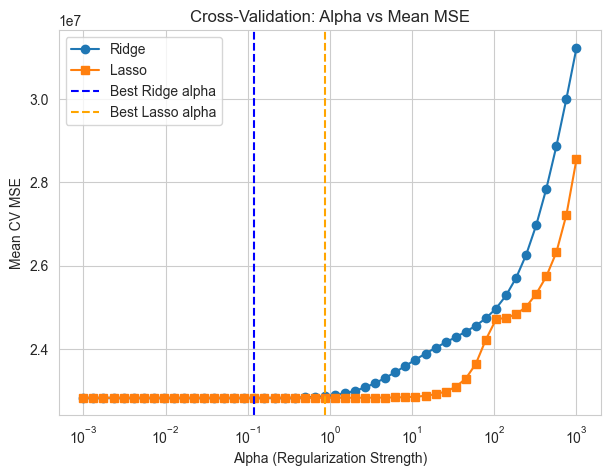

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(alphas, ridge_cv_mse, marker='o', label='Ridge')
plt.plot(alphas, lasso_cv_mse, marker='s', label='Lasso')
plt.xscale('log') # (because alpha effect is nonlinear)
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Mean CV MSE")
plt.title("Cross-Validation: Alpha vs Mean MSE")
plt.legend()
plt.grid(True)

plt.axvline(best_ridge_alpha, color='blue', linestyle='--', label='Best Ridge alpha')
plt.axvline(best_lasso_alpha, color='orange', linestyle='--', label='Best Lasso alpha')
plt.legend()
plt.show()

 

**Overall performance observation**  
Both curves show a near logistic shape, a common characteristic when optimizing regularization parameters. Too small an alpha (close to $10^{-3}$) leads to overfitting due to insufficient regularization, retaining errors and noise, resulting in high MSE. Too large an alpha (close to $10^3$) leads to underfitting due to excessive regularization, forcing coefficients to zero too much, missing important information, resulting in increased MSE. The optimal alpha is at the bottom of the curve, where MSE is lowest.  


## 5. Noise injection test  
 This tests model robustness by adding random noise to inputs to see how predictions are affected.

In [ ]:
X_train_noisy = X_train.copy()
np.random.seed(19)

for col in numerical_features:
    X_train_noisy[col] += np.random.normal(0, 1, size=len(X_train_noisy))

ridge_noisy = clone(best_ridge_model)
ridge_noisy.fit(X_train_noisy, y_train)
pred_ridge_noisy = ridge_noisy.predict(X_test)
mse = mean_squared_error(y_test, pred_ridge_noisy)
rmse_ridge_noisy = np.sqrt(mse)
r2_ridge_noisy = r2_score(y_test, pred_ridge_noisy)

lasso_noisy = clone(best_lasso_model)
lasso_noisy.fit(X_train_noisy, y_train)
pred_lasso_noisy = lasso_noisy.predict(X_test)
mse = mean_squared_error(y_test, pred_lasso_noisy)
rmse_lasso_noisy = np.sqrt(mse)
r2_lasso_noisy = r2_score(y_test, pred_lasso_noisy)

print(f"Ridge + Noise (numerical) - RMSE: {rmse_ridge_noisy:.2f}, R²: {r2_ridge_noisy:.4f}")
print(f"Lasso + Noise (numerical) - RMSE: {rmse_lasso_noisy:.2f}, R²: {r2_lasso_noisy:.4f}")



Ridge + Noise (numerical) - RMSE: 5100.63, R²: 0.8313
Lasso + Noise (numerical) - RMSE: 5099.42, R²: 0.8314


## Comparison of Model Performance Before and After Noise Injection

| Model  | RMSE (Before Noise) | RMSE (After Noise) | Change | R² (Before Noise) | R² (After Noise) | Change |
|--------|------------------|-----------------|-------|-----------------|----------------|------|
| Ridge  | 4716.54          | 5100.63         | +384.09 (8.14%) | 0.8558          | 0.8313         | -0.0245 |
| Lasso  | 4716.93          | 5099.42         | +382.49 (8.1%) | 0.8558          | 0.8314         | -0.0244 |

**Observations:**

- Both Ridge and Lasso models show a moderate increase in RMSE (~380–385) after adding Gaussian noise to numerical features, indicating a slight decrease in prediction accuracy.  
- R² decreases by ~0.024 for both models, meaning the models still explain over 83% of the variance in medical charges despite the noise.  
- The performance degradation is similar for Ridge and Lasso, suggesting both regularization methods are comparably robust to feature perturbations.

**Conclusion:**

- The linear models with L1/L2 regularization are reasonably stable and robust to small perturbations in the input features.  
- Noise Injection Test confirms that my models do not overfit and maintain predictive power, making them reliable choices for real-world medical cost prediction tasks.


## 6. Prediction 
This section allows the user to input patient information directly through the terminal.  The trained Ridge and Lasso models are then used to predict the expected medical charges based on the provided features, including engineered features like `age_bmi`, `smoke_bmi`, and `smoke_age`.  
Just run it to make prediction while inputing in the Terminal interface.



In [ ]:
def predict_medical_cost_terminal():
    try:
        age = int(input("Enter age (years): "))
        sex = input("Sex (only 'male' or 'female'): ").lower()
        bmi = float(input("BMI: "))
        children = int(input("Number of children: "))
        smoker = input("Is the patient a smoker? ('yes' or 'no'): ").lower()
        region = input("Enter region ('northeast','northwest','southeast','southwest'): ").lower()
        age_bmi = age * bmi
        smoke_bmi = bmi * (1 if smoker=='yes' else 0)
        smoke_age = age * (1 if smoker=='yes' else 0)
        
        X_input = pd.DataFrame({
            'age':[age],
            'bmi':[bmi],
            'children':[children],
            'age_bmi':[age_bmi],
            'smoke_bmi':[smoke_bmi],
            'smoke_age':[smoke_age],
            'sex_male':[1 if sex=='male' else 0],
            'smoker_yes':[1 if smoker=='yes' else 0],
            'region_northwest':[1 if region=='northwest' else 0],
            'region_southeast':[1 if region=='southeast' else 0],
            'region_southwest':[1 if region=='southwest' else 0]
        })
        
        ridge_pred = best_ridge_model.predict(X_input)[0]
        lasso_pred = best_lasso_model.predict(X_input)[0]
        
        print(f"\nPredicted medical charges:")
        print(f"  Ridge: ${ridge_pred:.2f}")
        print(f"  Lasso: ${lasso_pred:.2f}")
    
    except Exception as e:
        print("Error input:", e)

predict_medical_cost_terminal()



Predicted medical charges:
  Ridge: $2195.79
  Lasso: $2207.95


## 7. Conclusion

In this project, I successfully built predictive models for medical insurance charges using Ridge and Lasso regression. 

Key takeaways include:

- Data preprocessing and feature engineering (winsorization, `age_bmi`, `smoke_bmi`, `smoke_age`, one-hot encoding, scaling) were crucial for model performance.
- Model selection and regularization: GridSearchCV was used to optimize the `alpha` parameter, balancing bias and variance.
- Evaluation: Both Ridge and Lasso achieved similar performance on the test set (RMSE ≈ 4716, R² ≈ 0.856), demonstrating strong predictive ability.
- Robustness testing: Noise injection into numerical features caused a slight degradation in performance, indicating that the models are reasonably robust.
- Feature importance: Key predictors such as `smoker_yes`, `bmi`, and `age` strongly influence predicted charges, aligning with domain knowledge.

Finally, an interactive prediction function was implemented, allowing users to input new patient data and obtain predicted medical charges, making the model practical.
